In [1]:
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from datasets import Dataset, DatasetDict, load_from_disk

c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [3]:
tokenizer.vocab_size

28996

In [3]:
dataset = load_from_disk("MLM_TRAIN_data_256_wo_LIAR")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 54868
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 13717
    })
})

In [10]:
tokenizer.decode(dataset["train"][0]["input_ids"])

"to live in peace without any problems. [SEP] [CLS] MONESSEN, Pa. — Thirty years have passed, almost to the day, since the last blasts of the steel furnaces that were the reason for this city ' s existence. The steel mill is gone — used to film RoboCop, then demolished. Most of the people are gone, too, and those who remain are struggling to find a new purpose for this place. Last week, Donald J. Trump, the presumptive Republican presidential nominee, came here to declare that as president, he would revive the fortunes of the American steel industry — and"

In [11]:
tokenizer.decode(dataset["train"][0]["labels"])

"to live in peace without any problems. [SEP] [CLS] MONESSEN, Pa. — Thirty years have passed, almost to the day, since the last blasts of the steel furnaces that were the reason for this city ' s existence. The steel mill is gone — used to film RoboCop, then demolished. Most of the people are gone, too, and those who remain are struggling to find a new purpose for this place. Last week, Donald J. Trump, the presumptive Republican presidential nominee, came here to declare that as president, he would revive the fortunes of the American steel industry — and"

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 109745
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 27437
    })
})

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from transformers import BertConfig, BertForMaskedLM

vocab_size = tokenizer.vocab_size

config = BertConfig(
    vocab_size=vocab_size,
    num_hidden_layers=6,
    num_attention_heads=4,
    max_position_embeddings=256,
)

model = BertForMaskedLM(config).to(device)

print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(256, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [8]:
from transformers import (
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    TrainerCallback,
)

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)

In [8]:
dataset = DatasetDict(
    {
        "train": dataset["train"].remove_columns("word_ids"),
        "test": dataset["test"].remove_columns("word_ids"),
    }
)

In [11]:
# Example dataset (ensure you replace this with your actual dataset)
samples = [dataset["train"][i] for i in range(2)]  # Adjust as needed

# Apply the data collator to the samples (no need to pass tokenizer here)
batch = collator(samples)

# Print the decoded input IDs for each chunk in the batch
for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> to live in peace without any problems. [SEP] [CLS] MONESSE [MASK], Pa. — Thirty years have passed, almost to the day, since [MASK] [MASK] blasts of the steel furnaces that were the [MASK] for this city ' s existence [MASK] The [MASK] mill is gone — used [MASK] [MASK] RoboCop, then demolished [MASK] Most of [MASK] people are gone, too [MASK] [MASK] those who remain are struggling to [MASK] a new purpose for [MASK] place. Last [MASK] [MASK] Donald J [MASK] Trump, the presumptive Republican presidential nominee, came here to declare that as president, he would revive the [MASK] of the American steel industry [MASK] and'

'>>> Pennsylvania, Illinois — places with high immigration and illegal immigration. So I think the Left will go crazy. It [MASK] s what [MASK] do [MASK] They can ' t [MASK] [MASK]. So [MASK] more of it, he said. Marlow characterized the longstanding bizarre and terrible approach to immigration enforcement as an [MASK]licit promise that [MASK] you have to do is not c

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./training_prog_256_final1/results",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1000,
    logging_dir="./training_prog_256_final1/logs",
    logging_steps=500,
    save_strategy="epoch",
    fp16=True,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    overwrite_output_dir=False,
    save_total_limit=25,
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    callbacks=[early_stopping_callback],
)


trainer.train()

# LOAD MODEL


In [1]:
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import BertForMaskedLM

c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [ ]:
dataset = load_from_disk("MLM_TRAIN_data_128")

checkpoint_path = "./training_prog_128_final/results/checkpoint-50016"

model = BertForMaskedLM.from_pretrained(checkpoint_path)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [5]:
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(128, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [5]:
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 133364
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 33342
    })
})

In [12]:
samples = [dataset["validation"][i] for i in range(10000, 10001)]
samples_clean = [dataset["validation"][i] for i in range(10000, 10001)]
batch = whole_word_masking_data_collator(samples, tokenizer)

for chunk in batch["input_ids"]:
    print(f"\n'{tokenizer.decode(chunk)}'")


'the whole of the United States, or to the [MASK] that is feasible. [SEP] [CLS] [MASK] U. S. Supreme Court on Tuesday appeared [MASK] to rule against a Puerto Rican politician who maintained he cannot [MASK] retried on corruption charges involving a trip to Las Vegas to watch a boxing bout after his original conviction was thrown out. The [MASK] justices [MASK] the first [MASK] [MASK] of their new term in the appeal filed by [MASK] Martinez Maldonado, who served in Puerto Rico [MASK] s Senate from 2005 until his [MASK] conviction, and businessman Juan Bravo Fernandez, former president of a private security company. Several [MASK] [MASK] expressed skepticism about the defendants'


In [99]:
batch

{'input_ids': tensor([[ 1164,   170,  2029,  6145,   119,  7988,   103,   103,   103,  1127,
            103,   103, 12582,  2823,   119,  6652,  1111,   103,  6136,  1104,
           8499,  7179,   117,  1105,  1106,  1474,  1112,  1376,  1112,  1936,
           1164,  1123, 20673, 12645,   119,  8403,   119,  9198,   119,  1847,
            103,   119, 13580,   117,   170,  2623,  1740,  2575,  1150, 19961,
           1116,  1828,   119,  8499,   117,  1163,  1175,  1108, 11769,  3121,
          20279,  1107,  1103,  2322,  1115,  1103, 11550,  1104,  1103,  1886,
            103,  5733,  4707,  1107,  1828,   119,   103,   112,   188,  5010,
            119,  1124, 10035,  1115,  7179,  1156,  1267,   103,  7762,  1206,
            170,  2564,  1150,   103,  1155,  7553,  1104,  7640,  1112,  1119,
           1108,  2935,  1106,   103,  1103,   185, 19123,  3377,  1105,  1103,
           5554,  8499,  1104,  1103,  1704,  1728,   119,  1828,   119,  8499,
           1144,  1678,  11

In [13]:
batch = {key: value.to(device) for key, value in batch.items()}

with torch.no_grad():  # Disable gradient computation for inference
    output = model(**batch)  # Unpack the batch directly into the model

# Get the logits for the input sequence
logits = output.logits

# Find the positions of the masked tokens
masked_positions = (batch["labels"] != -100).nonzero(as_tuple=True)[1]

# Get the predicted token for each masked position
predicted_tokens = torch.argmax(logits[0, masked_positions], dim=-1)

# Decode the predicted token IDs back to words
predicted_words = tokenizer.decode(predicted_tokens)

# Get the actual token IDs at the masked positions
labels = batch["labels"]
actual_tokens = labels[0, masked_positions]

# Decode the token IDs to actual words
actual_words = tokenizer.decode(actual_tokens, skip_special_tokens=True)


# Decode the first sequence in the batch (assuming batch size is 1)
actual_sentence = tokenizer.decode(
    samples_clean[0]["input_ids"], skip_special_tokens=True
)

# Replace the masked tokens in input_ids with predicted tokens to form the predicted sentence
predicted_input_ids = batch["input_ids"][
    0
].clone()  # Clone the original input_ids to modify
predicted_input_ids[masked_positions] = (
    predicted_tokens  # Replace the masked positions with predicted tokens
)

# Decode the predicted sentence
predicted_sentence = tokenizer.decode(predicted_input_ids, skip_special_tokens=True)


print("PREDICTED")
print(f"WORDS: {predicted_words}")
print("\n")
print(f"SENTENCE: {predicted_sentence}")
print("\nREAL")
print(f"WORDS: {actual_words}")
print("\n")
print(f"SENTENCE: {actual_sentence}")

PREDICTED
WORDS: extent The poised be two won major months Governor ' 1994 justices


SENTENCE: the whole of the United States, or to the extent that is feasible. The U. S. Supreme Court on Tuesday appeared poised to rule against a Puerto Rican politician who maintained he cannot be retried on corruption charges involving a trip to Las Vegas to watch a boxing bout after his original conviction was thrown out. The two justices won the first major months of their new term in the appeal filed by Governor Martinez Maldonado, who served in Puerto Rico ' s Senate from 2005 until his 1994 conviction, and businessman Juan Bravo Fernandez, former president of a private security company. Several justices expressed skepticism about the defendants

REAL
WORDS: extent The ready be eight heard oral argument Hector ' 2011 justices


SENTENCE: the whole of the United States, or to the extent that is feasible. The U. S. Supreme Court on Tuesday appeared ready to rule against a Puerto Rican politician w

In [101]:
masked_positions

tensor([  6,   7,   8,  10,  11,  17,  40,  70,  76,  87,  93, 103],
       device='cuda:0')

In [ ]:
trainer_state_file = (
    "./training_prog_128_final5/results/checkpoint-42875/trainer_state.json"
)
log_dir_1 = "./training_prog_128_final5/logs/events.out.tfevents.1740385683.Matej.11056.0"  # Path to first tfevent file
log_dir_2 = "./training_prog_128_final5/logs/events.out.tfevents.1740393136.Matej.3044.0"  # Path to second tfevent file

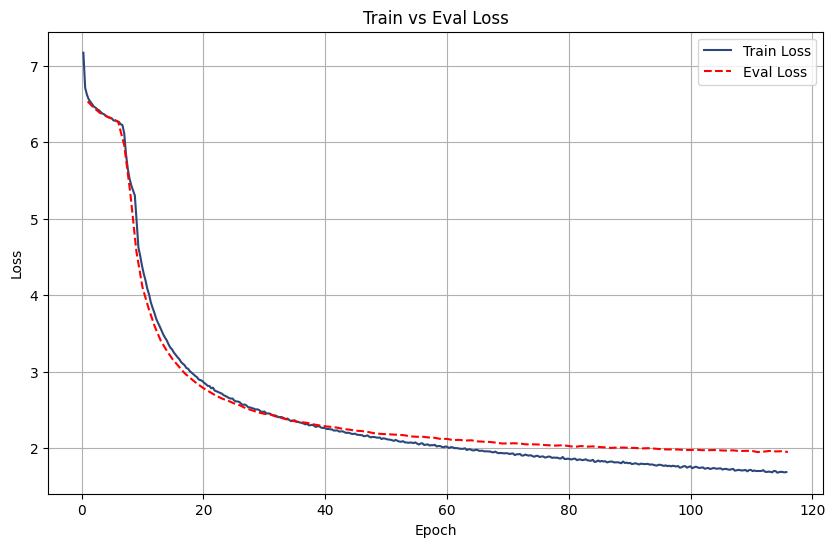

In [2]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Path to the directory containing the tfevent files
log_dir = "./training_prog_256_final1/logs"  # Path to the logs directory

# Define the number of steps per epoch
steps_per_epoch = 1715


# Function to load and extract data from a tfevent file
def extract_loss_data(tfevent_file):
    event_acc = EventAccumulator(tfevent_file)
    event_acc.Reload()

    # Extract scalars
    training_loss = event_acc.Scalars("train/loss")  # Training loss
    eval_loss = event_acc.Scalars("eval/loss")  # Evaluation loss

    # Get the steps and corresponding losses
    train_loss_steps = [scalar.step for scalar in training_loss]  # Get the step number
    train_loss_values = [scalar.value for scalar in training_loss]

    eval_loss_steps = [scalar.step for scalar in eval_loss]  # Get the step number
    eval_loss_values = [scalar.value for scalar in eval_loss]

    # Map steps to epochs
    train_loss_epochs = [step / steps_per_epoch for step in train_loss_steps]
    eval_loss_epochs = [step / steps_per_epoch for step in eval_loss_steps]

    return train_loss_epochs, train_loss_values, eval_loss_epochs, eval_loss_values


# Function to load all tfevent files from a directory and aggregate data
def aggregate_loss_data_from_directory(log_dir):
    tfevent_files = [
        os.path.join(log_dir, f) for f in os.listdir(log_dir) if "tfevents" in f
    ]

    train_loss_epochs = []
    train_loss_values = []
    eval_loss_epochs = []
    eval_loss_values = []

    # Extract data from each tfevent file
    for tfevent_file in tfevent_files:
        (
            t_train_loss_epochs,
            t_train_loss_values,
            t_eval_loss_epochs,
            t_eval_loss_values,
        ) = extract_loss_data(tfevent_file)
        train_loss_epochs.extend(t_train_loss_epochs)
        train_loss_values.extend(t_train_loss_values)
        eval_loss_epochs.extend(t_eval_loss_epochs)
        eval_loss_values.extend(t_eval_loss_values)

    return train_loss_epochs, train_loss_values, eval_loss_epochs, eval_loss_values


# Aggregate data from the logs directory
train_loss_epochs, train_loss_values, eval_loss_epochs, eval_loss_values = (
    aggregate_loss_data_from_directory(log_dir)
)

# Sort combined data by epoch (just in case they aren't ordered)
train_loss_epochs, train_loss_values = zip(
    *sorted(zip(train_loss_epochs, train_loss_values))
)
eval_loss_epochs, eval_loss_values = zip(
    *sorted(zip(eval_loss_epochs, eval_loss_values))
)

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss_epochs, train_loss_values, label="Train Loss", color="#2b4879")
plt.plot(
    eval_loss_epochs, eval_loss_values, label="Eval Loss", linestyle="--", color="red"
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Eval Loss")
plt.legend()
plt.grid()
plt.savefig("training_vs_eval_loss_combined_epoch.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Path to the directory containing the tfevent files
log_dir = "./training_prog_128_final5/logs"

# Find the tfevent file
tfevent_file = [
    os.path.join(log_dir, f) for f in os.listdir(log_dir) if "tfevents" in f
][0]

# Load the event file
event_acc = EventAccumulator(tfevent_file)
event_acc.Reload()

# List all tags
tags = event_acc.Tags()
print(tags)

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second'], 'distributions': [], 'tensors': ['args/text_summary', 'model_config/text_summary'], 'graph': False, 'meta_graph': False, 'run_metadata': []}


# CONTINUE TRAINING


In [1]:
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import BertForMaskedLM, BertConfig, TrainingArguments

c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [4]:
dataset = load_from_disk("MLM_TRAIN_data_256_wo_LIAR")

In [ ]:
checkpoint_path = "./training_prog_256_final1/results/checkpoint-36015"

model = BertForMaskedLM.from_pretrained(checkpoint_path, trust_remote_code=True)
model.to(device)
model.train()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(256, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
training_args = TrainingArguments(
    output_dir="./training_prog_256_final1/results",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1000,
    logging_dir="./training_prog_256_final1/logs",
    logging_steps=500,
    save_strategy="epoch",
    fp16=True,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    overwrite_output_dir=False,
    save_total_limit=25,
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    callbacks=[early_stopping_callback],
)

trainer.train(
    resume_from_checkpoint="./training_prog_256_final1/results/checkpoint-36015"
)